![title](images/header.png)

# Ve - Supervised Classification of eSBAE with CAFI data - multiple models
-------
This notebook performs a supervised classification of eSBAE points based on the validated data from systematic points (2015-2022) for training
This script estimates several models of forest change (deforestation, degradation, stable, NF) based on the visually interpreted data and eSBAE variables. 
The models are then combined to assign categories of change to all systematic points
This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [ ]:
#pip install --user git+https://github.com/BuddyVolly/sampling-handler
#!pip install xgboost

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt
import seaborn as sns

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling

from imblearn import FunctionSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

import folium
import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.10/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


## Parameters

In [2]:
# country area (ha) incomment the line with your country of interest
#GAB
#study_area = 26287600
#DRC
study_area = 232798200
#COG
#study_area = 34402400
#CMR
#study_area = 46497000
#EQG
#study_area = 2685800
#CAR
#study_area = 62009300

### 1 - data preparation
#### 1.1 - Import merged esbae and CEO interpreted data
Import the merged dataset from script 5e - with all the eSBAE columns

In [6]:
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/EQG/EQG_esbae_ceo_1522_merge.csv', delimiter=',')
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_esbae_ceo_1522_merge.csv', delimiter=',')
ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/DRC/DRC_esbae_ceo_1522_merge.csv', delimiter=',')
#ceo_esbae_1522 = pd.read_csv('/home/sepal-user/module_results/esbae/COG/COG_esbae_ceo_1522_merge.csv', delimiter=',')
ceo_esbae_1522.head()

images  mon_images  bfast_change_date  bfast_magnitude  bfast_means  cusum_change_date  cusum_confidence  cusum_magnitude     red_mean      red_sd      red_min  red_max     nir_mean      nir_sd      nir_min  nir_max   swir1_mean    swir1_sd    swir1_min  swir1_max   swir2_mean    swir2_sd    swir2_min  swir2_max    ndfi_mean     ndfi_sd     ndfi_min  ndfi_max  brightness_mean  brightness_sd  brightness_min  brightness_max  greenness_mean  greenness_sd  greenness_min  greenness_max  wetness_mean  wetness_sd  wetness_min  wetness_max  bs_slope_mean  bs_slope_sd  bs_slope_max  bs_slope_min  ewma_jrc_date  ewma_jrc_change  ewma_jrc_magnitude  mosum_jrc_date  mosum_jrc_change  mosum_jrc_magnitude  cusum_jrc_date  cusum_jrc_change  cusum_jrc_magnitude  ccdc_change_date  ccdc_magnitude  aspect  dw_class_mode  dw_tree_prob__max  dw_tree_prob__min  dw_tree_prob__stdDev  dw_tree_prob_mean   elevation  esa_lc20  esa_lc21  esri_lc17  esri_lc18  esri_lc19  esri_lc20  esri_lc21  gfc_gain  gfc_loss  gfc_lossyear  gfc_tc00  lang_tree_height  potapov_tree_height  slope  tmf_2016  tmf_2017  tmf_2018  tmf_2019  tmf_2020  tmf_defyear  tmf_degyear  tmf_main  tmf_sub                                        geometry  point_id  Change_Bin  Def_Bin  Deg_Bin  CAFI_LC_2015  chg_prob_cafi1520  def_prob_cafi1520  deg_prob_cafi1520  simple_combined  kmeans_chg  kmeans_def  kmeans_deg   plotid        lon       lat  sampleid email flagged collection_time analysis_duration sample_geom  chg_prob  Ref_FNF_2015 Ref_Regeneration  Ref_Change_1522 Ref_Change_Type_1522  ArtFor  ArtMine  InfraR  Urb  IndFor  Other Other_Desc  IndMine  IndAg  ArtAg  Ref_Year  Ref_NFtype  Ref_Ftype Commentaires  collection  interpreted  Ref_LCtype Ref_Change_Year_1522  Def2016  Def2017  Def2018  Def2019  Def2020  Def2021  Def2022  Deg2016  Deg2017  Deg2018  Deg2019  Deg2020  Deg2021  Deg2022  Defall  Degall  Stable  NF    sampling  ISO
0     143         107           2016.079       -61.259880    -2.558426           2021.575          0.534613      3939.410325  9823.183155  153.956357  9344.250000  10000.0  9823.183155  153.956357  9344.250000  10000.0  9823.183155  153.956357  9344.250000    10000.0  9823.183155  153.956357  9344.250000    10000.0  9823.183155  153.956357  9344.250000   10000.0      9823.183155     153.956357     9344.250000         10000.0     9823.183155    153.956357    9344.250000        10000.0   9823.183155  153.956357  9344.250000      10000.0      -4.071449     5.103150     11.654565    -24.850183          16813                1          -56.671647           16845                 1            -2.330874           16821                 1            -1.037568               0.0             0.0   184.0            1.0               75.0               11.0                  11.0               70.0  338.830109        10        10          2          2          2        2.0          2         0         0           NaN       100              26.0                   25    1.0         1         1         1         1         1          0.0          0.0      10.0     10.0  POINT (20.440804611463324 -0.3695613771074874)   1770848         NaN      NaN      NaN             8           0.050000           0.006000           0.045333         0.050000           1           1           1  1770848  20.440805 -0.369561       NaN   NaN     NaN             NaN               NaN         NaN       NaN           NaN              NaN              NaN                  NaN     NaN      NaN     NaN  NaN     NaN    NaN        NaN      NaN    NaN    NaN       NaN         NaN        NaN          NaN         NaN            0         NaN                  NaN        0        0        0        0        0        0        0        0        0        0        0        0        0        0     NaN     NaN     NaN   0  systematic  DRC
1     161         118             -1.000         0.000000     0.000000           2022.956          0.459192      2342.136421  9946.520763  101.978435  9528.666667  10000.0  9946.5

In [7]:
# output file of eSBAE points with model classification
out_file =  '/home/sepal-user/module_results/esbae/DRC/DRC_esbae_supervised_class_1522.csv'

## End of parameters

In [8]:
len(ceo_esbae_1522)

1973273

In [9]:
ceo_esbae_1522['kmeans_chg'].value_counts(dropna=False)

kmeans_chg
1    948929
2    828774
3    195570
Name: count, dtype: int64

In [10]:
pd.pivot_table(ceo_esbae_1522,values='point_id',index=['Ref_Change_Type_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg               1     2     3  Total
Ref_Change_Type_1522                         
Def                      5   258   717    980
Deg                      7   152   117    276
NF                     509  4121  1667   6297
Stable                 708  4012   874   5594
Total                 1229  8543  3375  13147

In [11]:
pd.pivot_table(ceo_esbae_1522,values='point_id',index=['Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg                 1       2       3  Total
Ref_Change_Year_1522                               
Def2016                  NaN    26.0    71.0     97
Def2017                  1.0    45.0   111.0    157
Def2018                  NaN    38.0   129.0    167
Def2019                  NaN    47.0   126.0    173
Def2020                  1.0    35.0   124.0    160
Def2021                  2.0    34.0    92.0    128
Def2022                  1.0    33.0    64.0     98
Deg2016                  NaN    45.0    15.0     60
Deg2017                  1.0    13.0     9.0     23
Deg2018                  1.0    16.0    15.0     32
Deg2019                  2.0    18.0    20.0     40
Deg2020                  1.0    25.0    21.0     47
Deg2021                  1.0    14.0    20.0     35
Deg2022                  1.0    21.0    17.0     39
NF                     509.0  4121.0  1667.0   6297
Stable                 708.0  4012.0   874.0   5594
Total                 1229.0  8543.0  3375.0  13147

In [12]:
all_ceo_cols = ceo_esbae_1522.columns.tolist()

# Display the list of column names
print(all_ceo_cols)

['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',

In [13]:
#training columns
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    #'images', 'mon_images',
'bfast_change_date', 'bfast_magnitude', 'bfast_means', 
    'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 
    'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 
    'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 
    'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 
    'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
    'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 
    'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 
    'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 
    'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 
    'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 
    'ccdc_change_date', 'ccdc_magnitude', 'aspect', 
    'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 
    'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 
    'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'potapov_tree_height', 'slope', 
    'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub',]

In [14]:
df = ceo_esbae_1522

### 1.2 where/what are NAs
evaluate and replace no data values

In [15]:
# Initialize a dictionary to store the counts by column
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'as

In [16]:
# Specify the columns to replace NaN with 0 (categorical data)
columns_to_fill = ['gfc_lossyear', 'gfc_gain','gfc_loss', 'lang_tree_height', 'esa_lc20', 'esa_lc21', 'esri_lc20',  'esri_lc21' , 'esri_lc19', 'esri_lc18', 'esri_lc17', 
                   'potapov_tree_height','elevation','slope', 'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'aspect']

# Set NaN values in the selected columns to 0
df[columns_to_fill] = df[columns_to_fill].fillna(0)

In [17]:
# Specify the columns you want to impute with the mean value - continuous data
columns_to_impute = ['dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__stdDev','dw_tree_prob_mean', 'dw_tree_prob__min']

# Impute NaN values in the selected columns with the mean
for column in columns_to_impute:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

In [18]:
#check for remaining missing counts - when there are only 0's you may proceed to next step
missing_counts = {}

# Count missing values and sum the counts by column
for column in eSBAE_cols:
    missing_counts[column] = df[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'as

In [19]:
df['Stable'].value_counts(dropna=False)

Stable
NaN    1960126
0.0       7553
1.0       5594
Name: count, dtype: int64

In [20]:
#convert to geo data frame for mapping
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']))

In [21]:
interpreted = gdf[gdf['interpreted'] == 1]

### 1.3 Run classifications on entire eSBAE dataset trained with CEO interpreted data

#### 4 individual models
we create binary models for deforestation, degradation, stable and non-forest based on visually interpreted data from CEO

In [22]:
# predictors used change/nochange classification
gdf['def_prob'] = clf.binary_probability_classification(gdf, 'Defall', eSBAE_cols, outlier=False)

OOB Score is 0.7766790902867574


array([<Axes: title={'center': 'def_prob'}>], dtype=object)

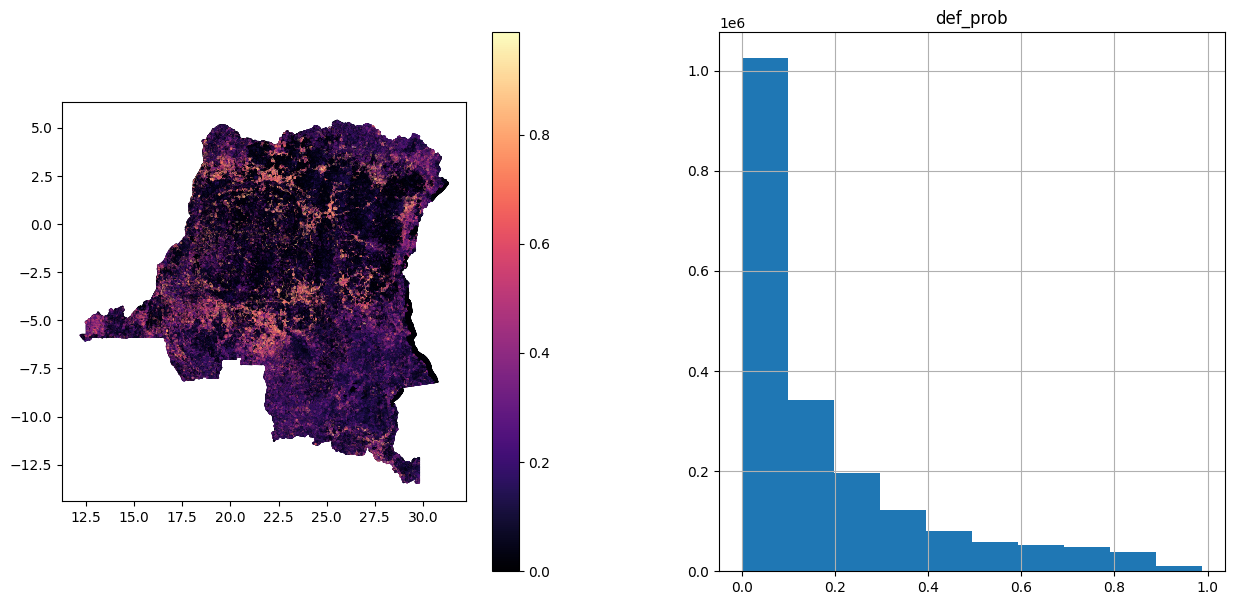

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('def_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('def_prob', ax=ax[1])

In [24]:
# predictors used change/nochange classification
gdf['deg_prob'] = clf.binary_probability_classification(gdf, 'Degall', eSBAE_cols, outlier=False)

OOB Score is 0.6952917015288659


array([<Axes: title={'center': 'deg_prob'}>], dtype=object)

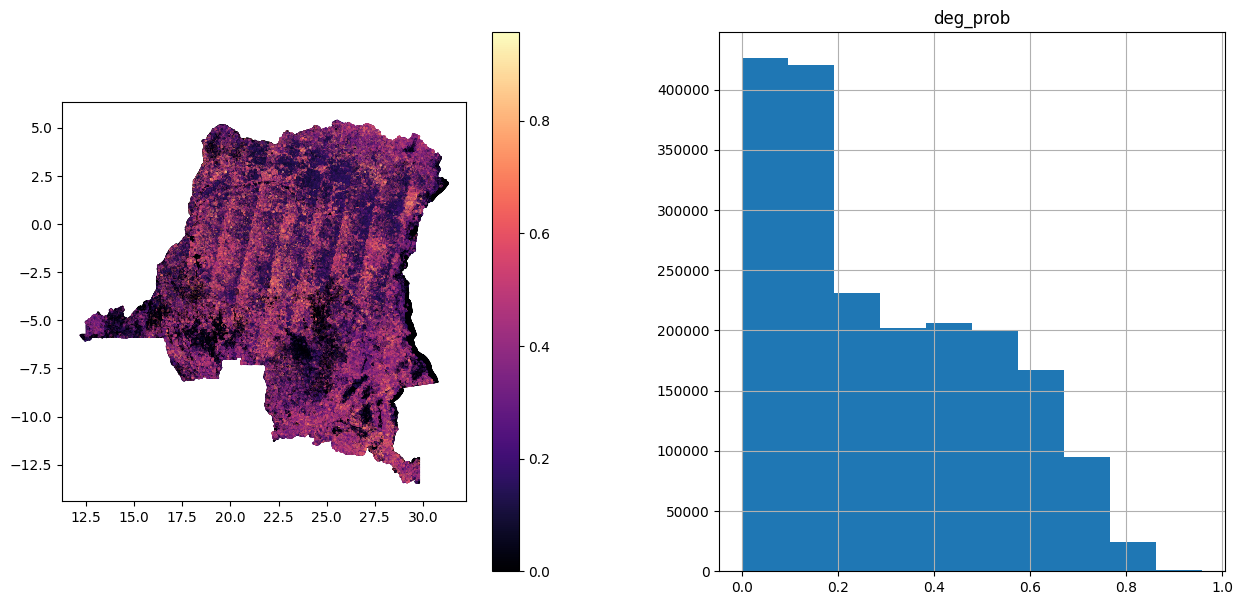

In [25]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('deg_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('deg_prob', ax=ax[1])

In [26]:
# predictors used change/nochange classification
gdf['stable_prob'] = clf.binary_probability_classification(gdf, 'Stable', eSBAE_cols, outlier=False)

OOB Score is 0.8191982961892447


array([<Axes: title={'center': 'stable_prob'}>], dtype=object)

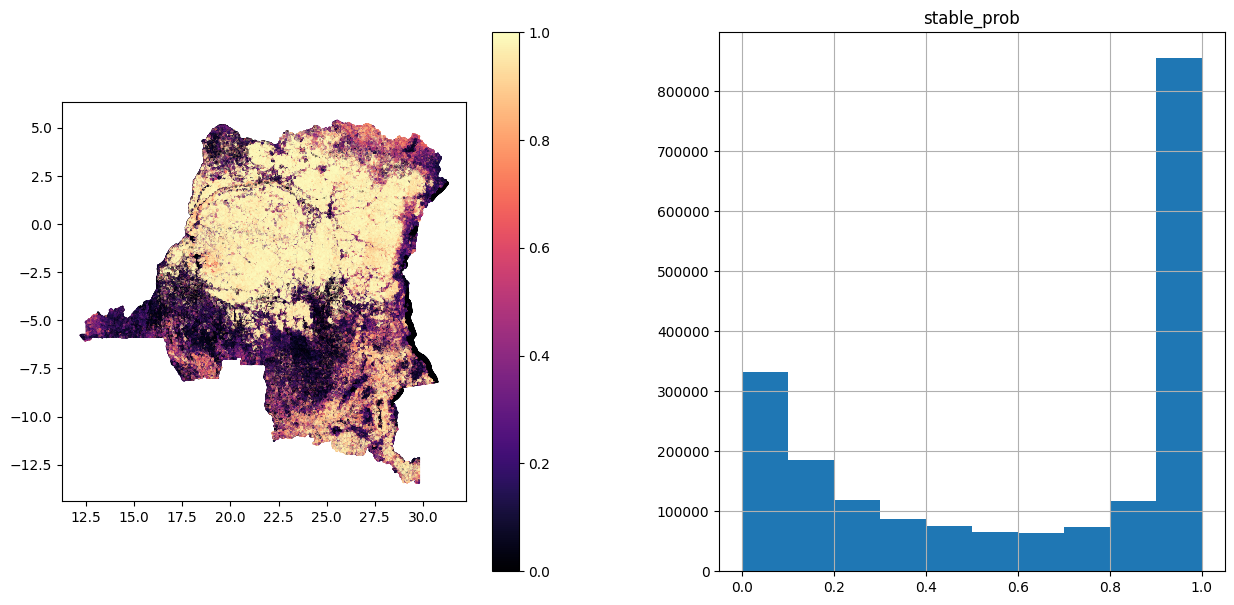

In [27]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('stable_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('stable_prob', ax=ax[1])

In [28]:
# predictors used change/nochange classification
gdf['nf_prob'] = clf.binary_probability_classification(gdf, 'NF', eSBAE_cols, outlier=False)

OOB Score is 0.7920100259822133


array([<Axes: title={'center': 'nf_prob'}>], dtype=object)

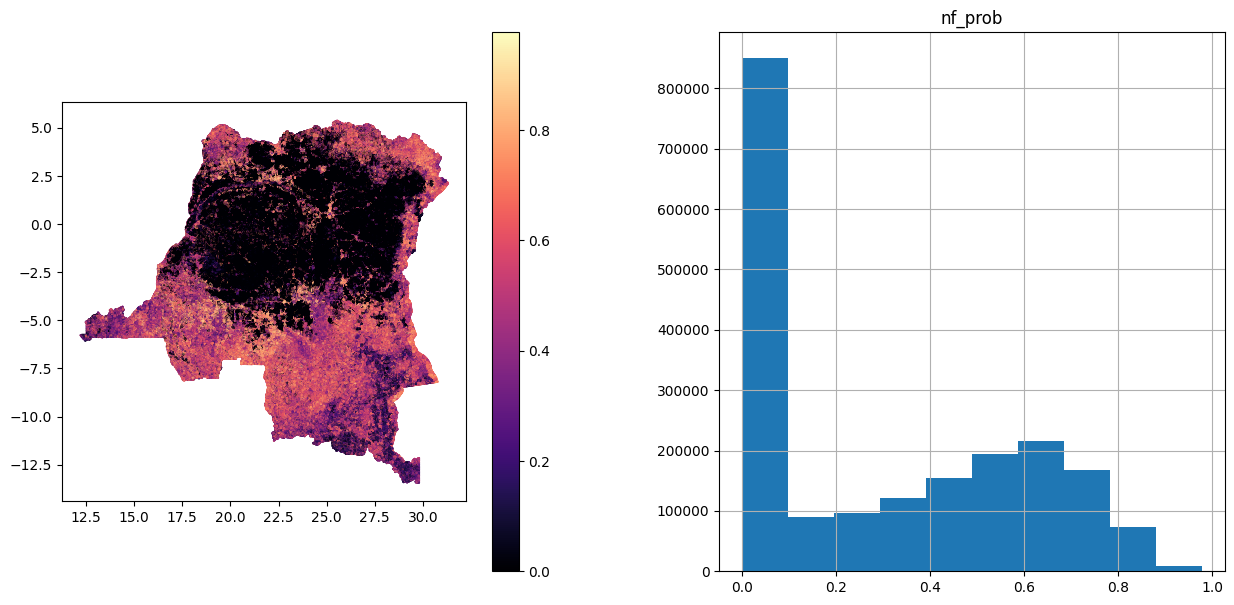

In [29]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

gdf.plot('nf_prob', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
gdf.hist('nf_prob', ax=ax[1])

In [30]:
interpreted_rows = gdf[gdf['interpreted'] == 1]

##### looking at validated data in comparison to model

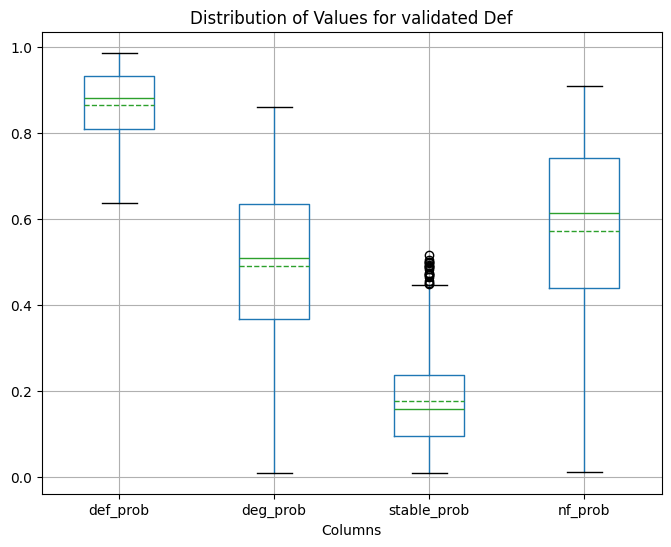

         def_prob    deg_prob  stable_prob     nf_prob
count  980.000000  980.000000   980.000000  980.000000
mean     0.865181    0.491769     0.175468    0.572971
std      0.080609    0.183849     0.105591    0.211706
min      0.637333    0.010000     0.010000    0.012000
25%      0.810000    0.367167     0.095333    0.440333
50%      0.881333    0.510000     0.158000    0.615000
75%      0.932000    0.635333     0.236667    0.741333
max      0.987333    0.860667     0.515333    0.908667


In [31]:
# Filter rows by a interpreted change category 
selected_category = 'Def'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

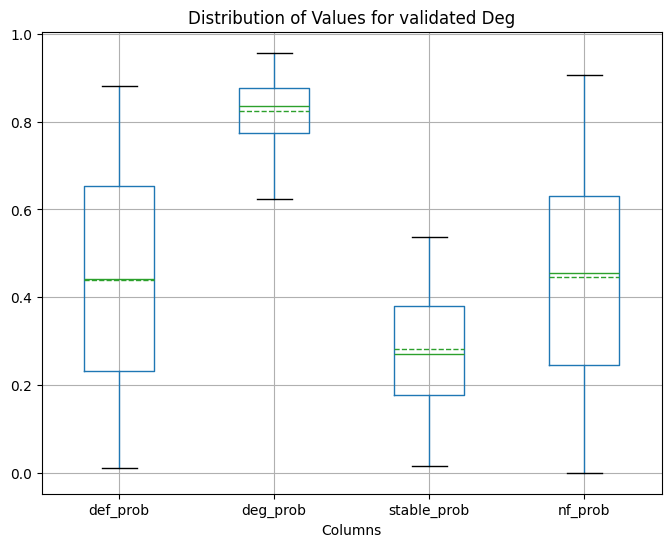

         def_prob    deg_prob  stable_prob     nf_prob
count  276.000000  276.000000   276.000000  276.000000
mean     0.437850    0.823778     0.282162    0.446396
std      0.243136    0.069972     0.132322    0.234831
min      0.010000    0.622667     0.014000    0.000000
25%      0.231000    0.773667     0.177667    0.244333
50%      0.442333    0.836667     0.270333    0.455667
75%      0.654333    0.877333     0.380833    0.629667
max      0.880667    0.957333     0.538000    0.906000


In [32]:
# Filter rows by a interpreted change category 
selected_category = 'Deg'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

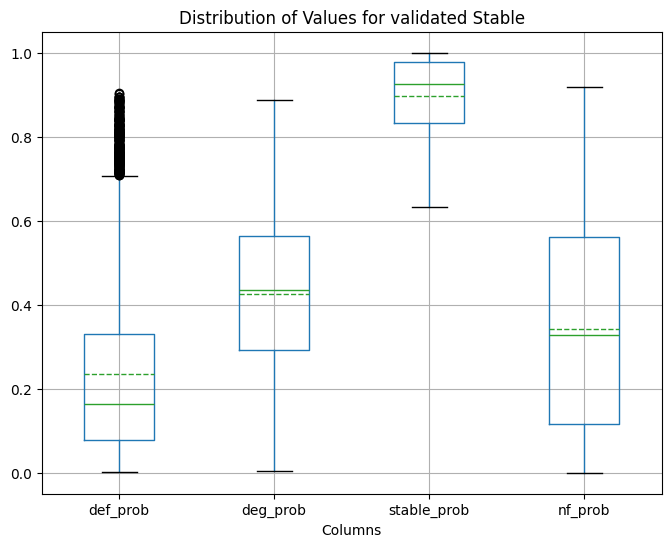

          def_prob     deg_prob  stable_prob      nf_prob
count  5594.000000  5594.000000  5594.000000  5594.000000
mean      0.233933     0.426202     0.897591     0.342810
std       0.206831     0.180410     0.092065     0.247016
min       0.001333     0.002667     0.632667     0.000000
25%       0.078667     0.292667     0.832833     0.114667
50%       0.164000     0.434000     0.925333     0.327333
75%       0.330667     0.563333     0.977333     0.560667
max       0.904667     0.887333     1.000000     0.918000


In [33]:
# Filter rows by a interpreted change category 
selected_category = 'Stable'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

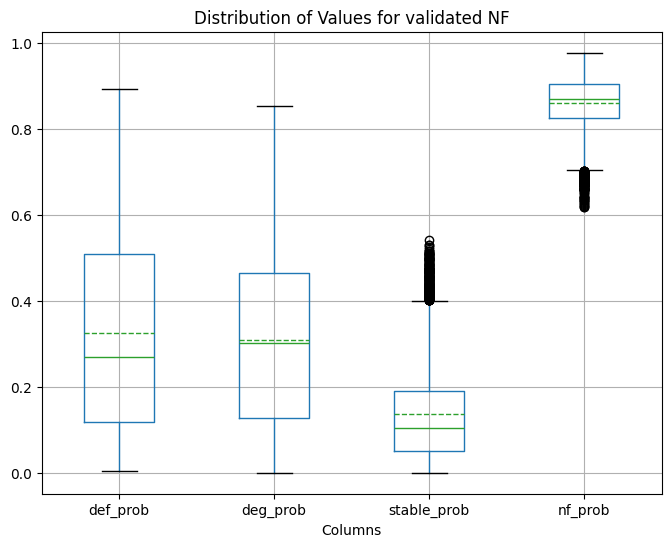

          def_prob     deg_prob  stable_prob      nf_prob
count  6297.000000  6297.000000  6297.000000  6297.000000
mean      0.324072     0.307435     0.135251     0.859377
std       0.235700     0.206488     0.109755     0.062064
min       0.004667     0.000000     0.000000     0.617333
25%       0.117333     0.126000     0.050000     0.824000
50%       0.268667     0.301333     0.104667     0.868667
75%       0.508000     0.465333     0.190000     0.904667
max       0.893333     0.852000     0.542000     0.977333


In [34]:
# Filter rows by a interpreted change category 
selected_category = 'NF'
selected_rows = interpreted_rows[interpreted_rows['Ref_Change_Type_1522'] == selected_category]

# List of columns to analyze
columns_to_analyze = ['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']

# Calculate statistics
statistics = selected_rows[columns_to_analyze].describe()

# Create a box plot with mean and median markers
fig, ax = plt.subplots(figsize=(8, 6))
selected_rows.boxplot(column=['def_prob', 'deg_prob', 'stable_prob', 'nf_prob'], vert=True, showmeans=True, meanline=True, ax=ax)

# Set custom labels for mean and median
#ax.set_xticklabels(['Value1', 'Value2'])
ax.set_xlabel('Columns')
ax.set_title(f'Distribution of Values for validated {selected_category}')

plt.show()

# Display summary statistics
print(statistics)

#### decision tree to assign values to categories from models

In [35]:
threshold = 0.8

In [36]:
gdf['sim_def'] = (gdf['def_prob'] > threshold).astype(int)
gdf['sim_deg'] = (gdf['deg_prob'] > threshold).astype(int)
gdf['sim_stable'] = (gdf['stable_prob'] > threshold).astype(int)
gdf['sim_nf'] = (gdf['nf_prob'] > threshold).astype(int)

In [37]:
gdf['max_prob'] = gdf[['def_prob', 'deg_prob', 'stable_prob', 'nf_prob']].idxmax(axis=1)

# Replace the string in a specific column ('column_name')
gdf['max_prob'] = gdf['max_prob'].str.replace('_prob', '')

gdf['max_prob'].value_counts(dropna=False)

max_prob
stable    1123827
nf         729877
def         86828
deg         32741
Name: count, dtype: int64

In [38]:
# Calculate the proportions and areas based on max probability classification
prob_counts = gdf['max_prob'].value_counts()
prob_percentage = (prob_counts / len(gdf)) * 100
area = (prob_percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_prob = pd.DataFrame({
    'Value Counts': prob_counts,
    'Percentage of Total Rows': prob_percentage,
    'area': area
})


# Print the result DataFrame
print(result_prob)

          Value Counts  Percentage of Total Rows      area
max_prob                                                  
stable         1123827                        57 132584241
nf              729877                        37  86107727
def              86828                         4  10243591
deg              32741                         2   3862641


In [39]:
# Define a function to check conditions and return the corresponding label
# check the order of the decisions which has an effect on the result
# in the Gabon case the decisions are in order or area stable > deg > def
def classify(row):
    if row['sim_stable'] >= 1:
        return 'Stable'
    elif row['sim_def'] >= 1:
        return 'Def'
    elif row['sim_deg'] >= 1:
        return 'Deg'
    else:
        return 'NF'

# Apply the function to create a new 'classification' column
gdf['prob_class'] = gdf.apply(classify, axis=1)

# Display the DataFrame with the new column
gdf['prob_class'].value_counts(dropna=False)

prob_class
Stable    971214
NF        954748
Def        43632
Deg         3679
Name: count, dtype: int64

In [40]:
# Calculate the proportions and areas based on decision tree classification
prob_counts = gdf['prob_class'].value_counts()
prob_percentage = (prob_counts / len(gdf)) * 100
area = (prob_percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_prob = pd.DataFrame({
    'Value Counts': prob_counts,
    'Percentage of Total Rows': prob_percentage,
    'area': area
})


# Print the result DataFrame
print(result_prob)

            Value Counts  Percentage of Total Rows      area
prob_class                                                  
Stable            971214                        49 114579620
NF                954748                        48 112637033
Def                43632                         2   5147514
Deg                 3679                         0    434032


In [41]:
# Group by the selected columns and count occurrences
result_df = gdf.groupby(['prob_class', 'Defall', 'Degall', 'Stable', 'NF']).size().reset_index(name='count')

# Display the result
print(result_df)

   prob_class  Defall  Degall  Stable  NF  count
0         Def       0       0       0   1    142
1         Def       0       0       1   0     82
2         Def       0       1       0   0     17
3         Def       1       0       0   0    763
4         Deg       0       0       0   1      8
5         Deg       0       0       1   0      2
6         Deg       0       1       0   0    168
7          NF       0       0       0   1   6147
8          NF       0       0       1   0    920
9          NF       0       1       0   0     91
10         NF       1       0       0   0    217
11     Stable       0       0       1   0   4590


In [42]:
# Create a new column 'Count' based on the conditions to determine if points are in multiple classes
gdf['Count'] = gdf[['sim_def', 'sim_deg', 'sim_stable', 'sim_nf']].sum(axis=1)

# Display the cross-tabulated counts
cross_tab = pd.crosstab(index=gdf['Count'], columns="Count")
print(cross_tab)

col_0    Count
Count         
0       902507
1      1055021
2        15352
3          393


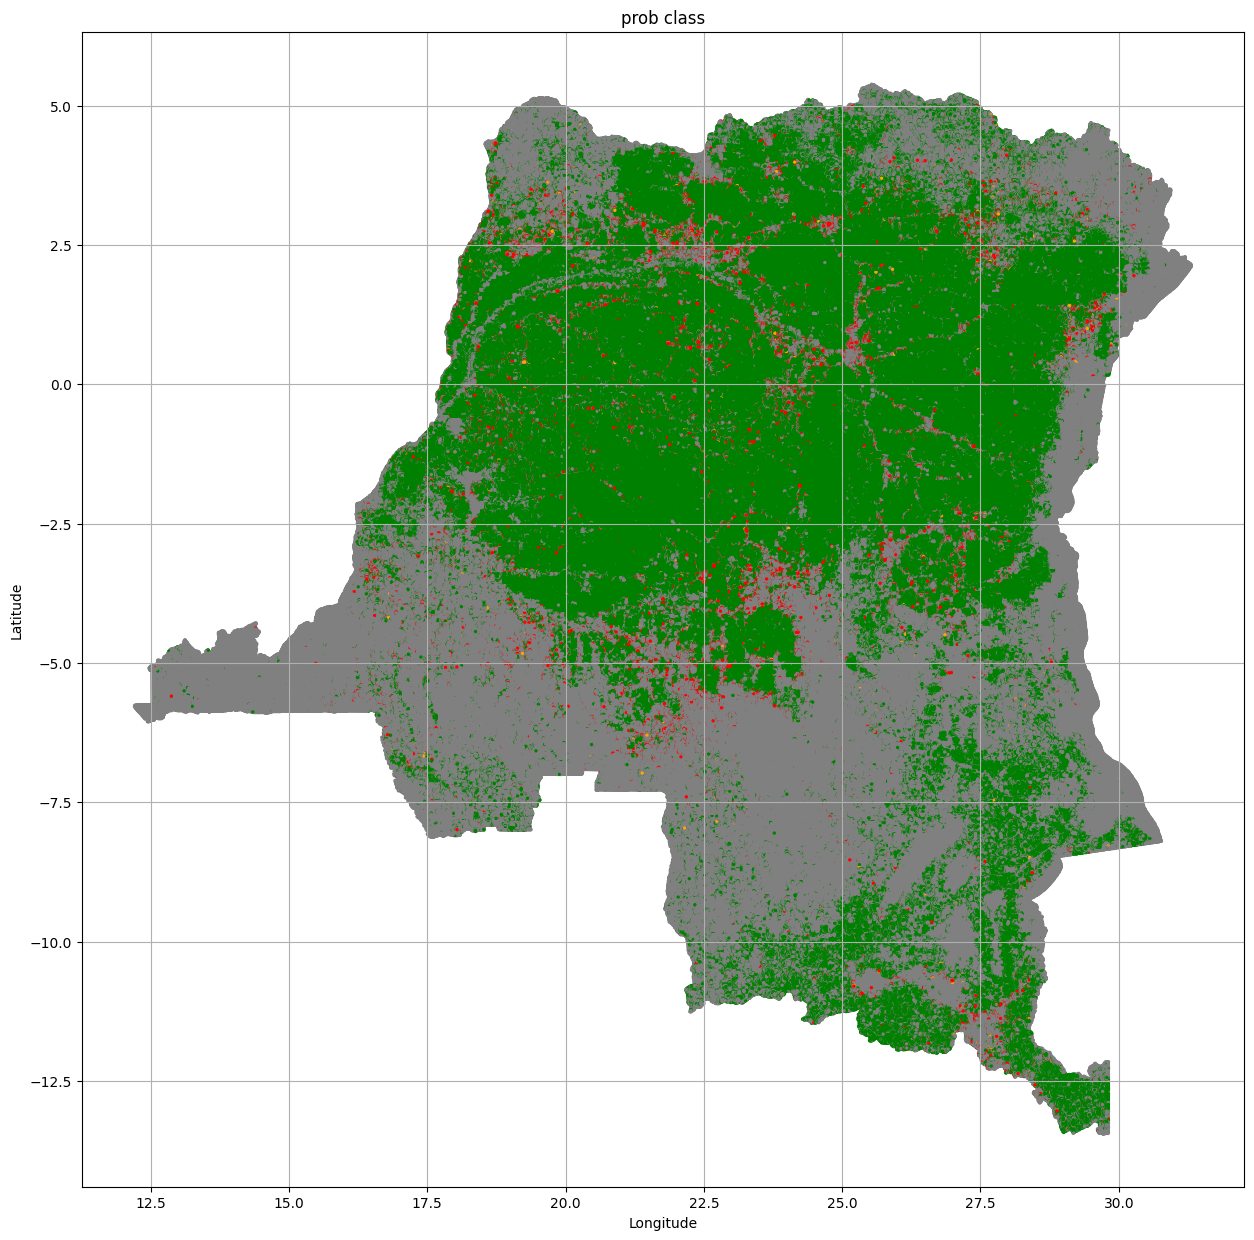

In [43]:
# plot point classes
category_colors = {
    'Def': 'red',
    'Deg': 'orange',
    'Stable': 'green',
    'NF': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['prob_class'].map(category_colors), s=2)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('prob class')
plt.grid()
plt.show()

#### Supervised classifications

In [44]:
# Assuming X contains your attribute columns and y contains your target labels
X = interpreted[eSBAE_cols]
y = interpreted['Ref_Change_Type_1522']

In [45]:
#check for remaining missing counts
missing_counts = {}

# Count missing values and sum the counts by column
for column in X.columns:
    missing_counts[column] = X[column].isna().sum()

# Print the counts
print(missing_counts)

{'bfast_change_date': 0, 'bfast_magnitude': 0, 'bfast_means': 0, 'cusum_change_date': 0, 'cusum_confidence': 0, 'cusum_magnitude': 0, 'red_mean': 0, 'red_sd': 0, 'red_min': 0, 'red_max': 0, 'nir_mean': 0, 'nir_sd': 0, 'nir_min': 0, 'nir_max': 0, 'swir1_mean': 0, 'swir1_sd': 0, 'swir1_min': 0, 'swir1_max': 0, 'swir2_mean': 0, 'swir2_sd': 0, 'swir2_min': 0, 'swir2_max': 0, 'ndfi_mean': 0, 'ndfi_sd': 0, 'ndfi_min': 0, 'ndfi_max': 0, 'brightness_mean': 0, 'brightness_sd': 0, 'brightness_min': 0, 'brightness_max': 0, 'greenness_mean': 0, 'greenness_sd': 0, 'greenness_min': 0, 'greenness_max': 0, 'wetness_mean': 0, 'wetness_sd': 0, 'wetness_min': 0, 'wetness_max': 0, 'bs_slope_mean': 0, 'bs_slope_sd': 0, 'bs_slope_max': 0, 'bs_slope_min': 0, 'ewma_jrc_date': 0, 'ewma_jrc_change': 0, 'ewma_jrc_magnitude': 0, 'mosum_jrc_date': 0, 'mosum_jrc_change': 0, 'mosum_jrc_magnitude': 0, 'cusum_jrc_date': 0, 'cusum_jrc_change': 0, 'cusum_jrc_magnitude': 0, 'ccdc_change_date': 0, 'ccdc_magnitude': 0, 'as

In [46]:
unique_labels = np.unique(y)
unique_labels = y.value_counts().index
# Specify the unique labels in your target variable as classes
unique_labels = np.unique(y)  # Or use the appropriate method based on your data
unique_labels

array(['Def', 'Deg', 'NF', 'Stable'], dtype=object)

In [47]:
# Split the data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
class_weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.unique(y), y=y_train)
class_weights
# Create a dictionary to map class labels to their respective class weights
class_weight_dict = dict(zip(unique_labels, class_weights))
class_weight_dict

{'Def': 3.388208762886598,
 'Deg': 11.790358744394618,
 'NF': 0.5179767533490938,
 'Stable': 0.5919067987393066}

In [49]:
#Balanced random forest classifier
#clf = BalancedRandomForestClassifier(n_estimators=1500, random_state=42, oob_score=True,class_weight=class_weight_dict)
clf = BalancedRandomForestClassifier(n_estimators=1500, random_state=42)

# Fit the classifier to your training data
clf.fit(X_train, y_train)

# Make predictions on new data
gdf['balRF_pred'] = clf.predict(gdf[eSBAE_cols])

y_pred = clf.predict(X_test)

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

         Def       0.25      0.61      0.35       204
         Deg       0.07      0.40      0.12        53
          NF       0.79      0.62      0.69      1221
      Stable       0.83      0.63      0.72      1152

    accuracy                           0.62      2630
   macro avg       0.49      0.56      0.47      2630
weighted avg       0.75      0.62      0.67      2630



In [50]:
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.6178707224334601


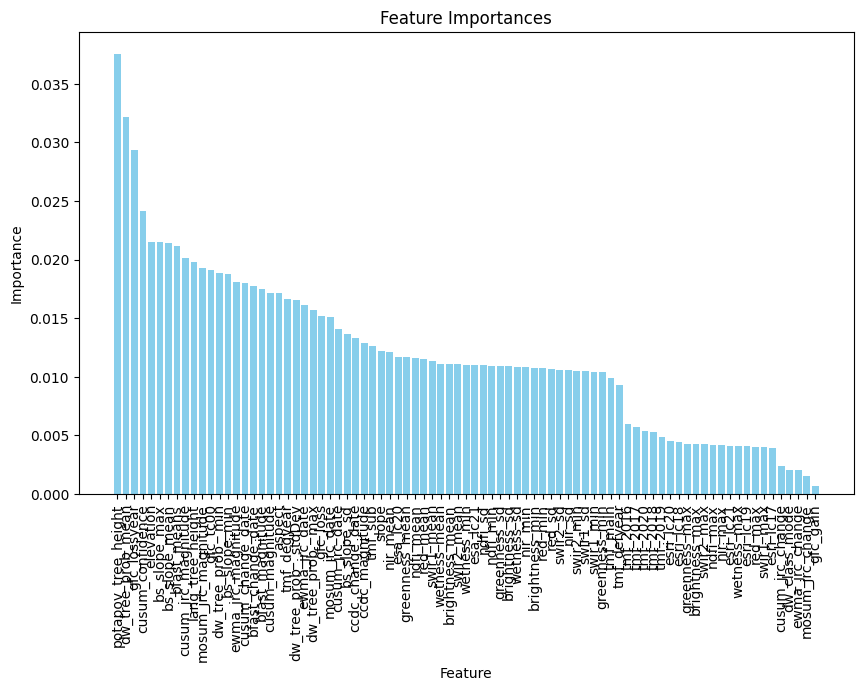

In [51]:
# Get feature importances
importances = clf.feature_importances_

# Get column names
column_names = X_train.columns

# Sort feature importances in descending order
indices = (-importances).argsort()

# Plot feature importances with column names
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="skyblue", align="center")
plt.xticks(range(X_train.shape[1]), column_names[indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [52]:
# Calculate the proportions of classified points
value_counts = gdf['balRF_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

            Value Counts  Percentage of Total Rows      area
balRF_pred                                                  
Stable           1078977                        55 127293032
NF                630730                        32  74410793
Def               143093                         7  16881492
Deg               120473                         6  14212883


In [53]:
# Create an instance of the random forest classifier
#clf = RandomForestClassifier(n_estimators=1000, random_state=42, oob_score=True) # too low
clf = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight=class_weight_dict)
# Fit the classifier to your training data
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
# Make predictions on new data
gdf['RF_pred'] = clf.predict(gdf[eSBAE_cols])

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

         Def       0.32      0.06      0.11       204
         Deg       0.00      0.00      0.00        53
          NF       0.71      0.85      0.77      1221
      Stable       0.79      0.77      0.78      1152

    accuracy                           0.74      2630
   macro avg       0.45      0.42      0.41      2630
weighted avg       0.70      0.74      0.71      2630



In [54]:
# Calculate the proportions
value_counts = gdf['RF_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

         Value Counts  Percentage of Total Rows      area
RF_pred                                                  
Stable        1176137                        60 138755548
NF             782329                        40  92295786
Def             14579                         1   1719967
Deg               228                         0     26898


In [55]:
#CART Model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Step 3: Predict on the Testing Dataset
y_pred = model.predict(X_test)
gdf['CART_pred'] = model.predict(gdf[eSBAE_cols])
# Step 4: Evaluate the Model (Optional)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on the test set: {accuracy}")

# Get a classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

Accuracy on the test set: 0.644106463878327
              precision    recall  f1-score   support

         Def       0.22      0.21      0.21       204
         Deg       0.00      0.00      0.00        53
          NF       0.68      0.71      0.70      1221
      Stable       0.71      0.68      0.69      1152

    accuracy                           0.64      2630
   macro avg       0.40      0.40      0.40      2630
weighted avg       0.64      0.64      0.64      2630



In [56]:
# Calculate the proportions
value_counts = gdf['CART_pred'].value_counts()
percentage = (value_counts / len(gdf)) * 100
area = (percentage * study_area)/100

pd.set_option('display.float_format', '{:.0f}'.format)

# Create a DataFrame to display the results
result_df = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total Rows': percentage,
    'area': area
})


# Print the result DataFrame
print(result_df)

           Value Counts  Percentage of Total Rows      area
CART_pred                                                  
Stable          1143972                        58 134960861
NF               720303                        37  84978227
Def               72412                         4   8542854
Deg               36586                         2   4316258


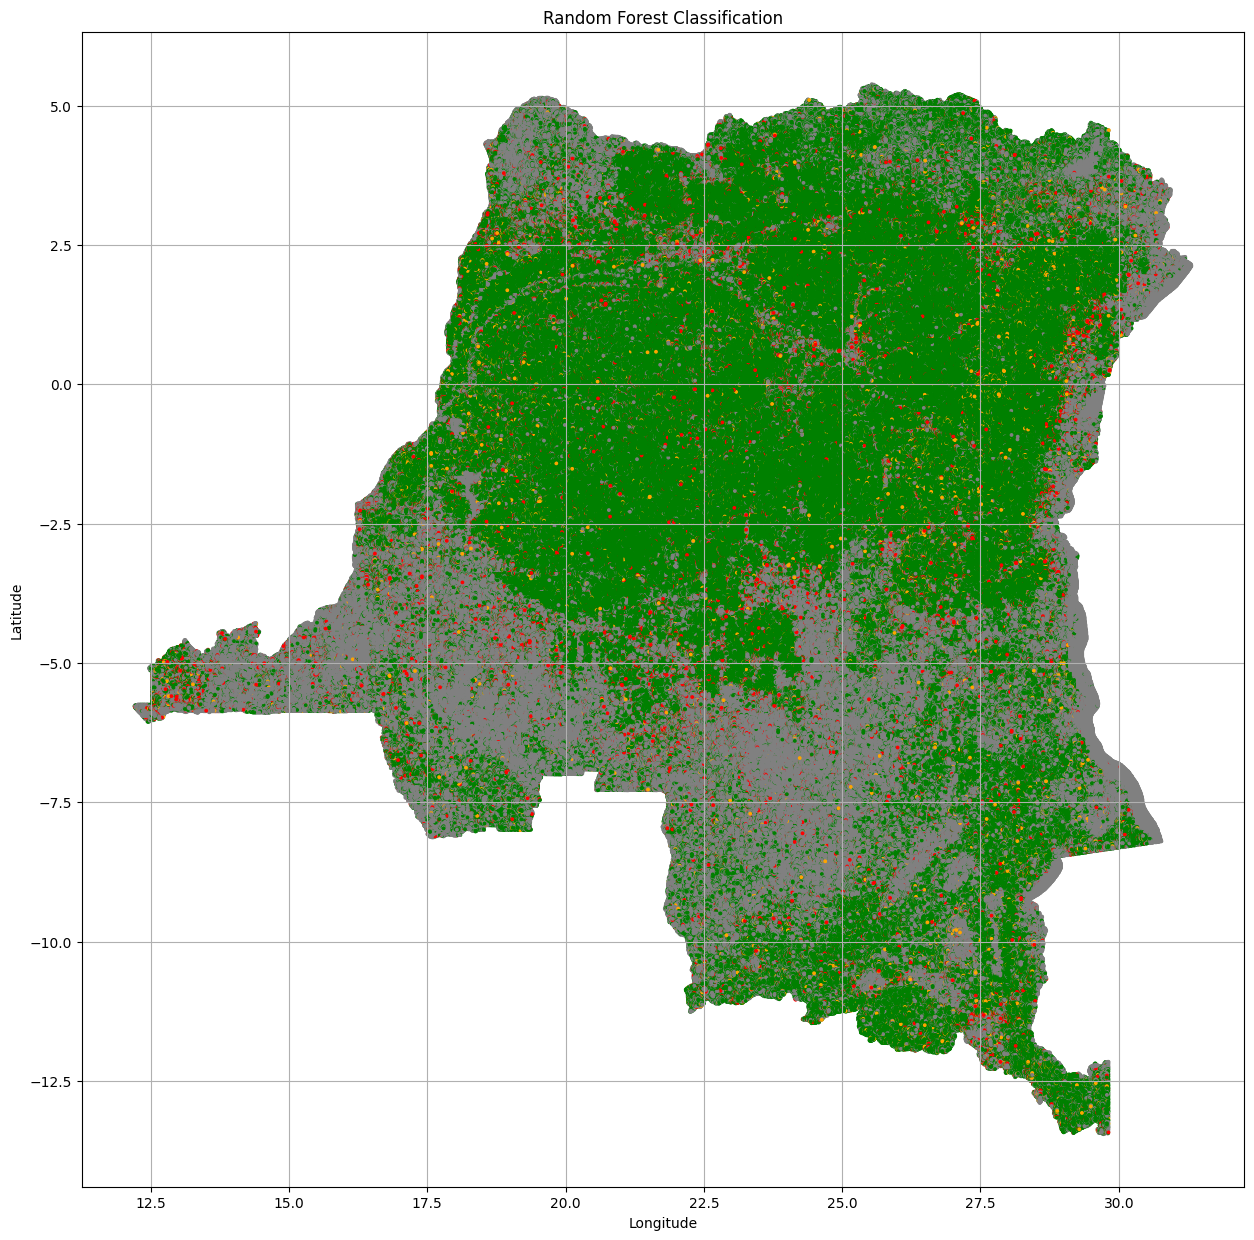

In [65]:
category_colors = {
    'Def': 'red',
    'Deg': 'orange',
    'Stable': 'green',
    'NF': 'grey'
}

plt.figure(figsize=(15, 15))
plt.scatter(gdf['lon'], gdf['lat'], c=gdf['CART_pred'].map(category_colors), s=3)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Random Forest Classification')
plt.grid()
plt.show()

#### add years to all points

In [74]:
# convert dates to years
gdf['cusum_change_year'] = np.floor(gdf['cusum_change_date']).astype(int)
gdf['ccdc_change_year'] = np.floor(gdf['ccdc_change_date']).astype(int)
gdf['bfast_change_year'] = np.floor(gdf['bfast_change_date']).astype(int)

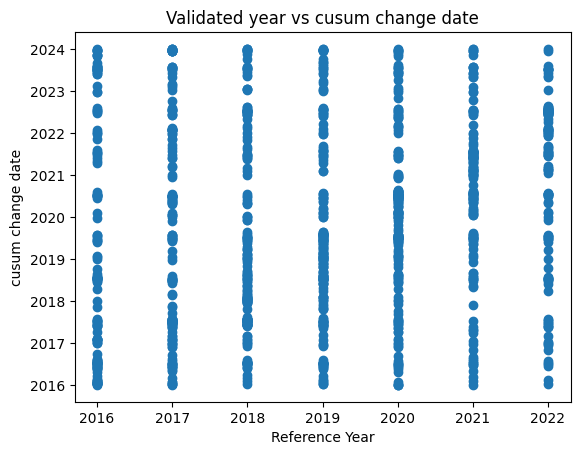

In [75]:
# Plotting validated data vs cusum change date
plt.scatter(gdf['Ref_Year'], gdf['cusum_change_date'])
plt.xlabel('Reference Year')
plt.ylabel('cusum change date')
plt.title('Validated year vs cusum change date')
plt.show()

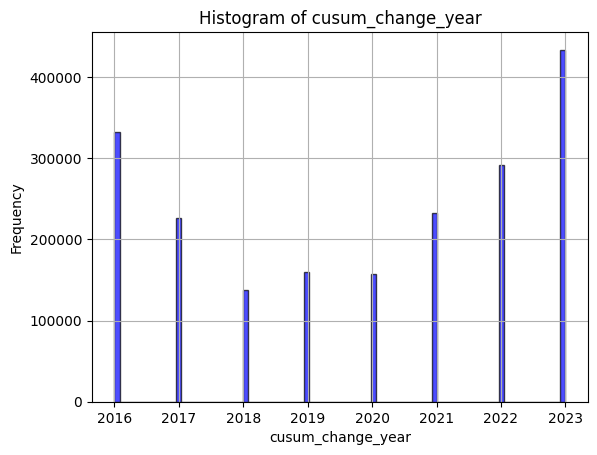

In [76]:
# plot histogram of cusum change
plt.hist(gdf['cusum_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of cusum_change_year')
plt.xlabel('cusum_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

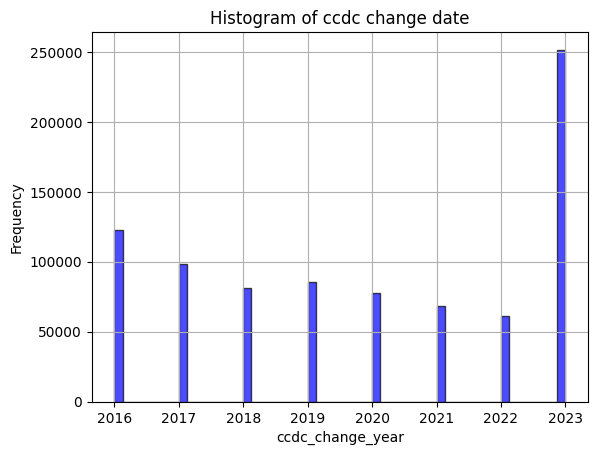

In [77]:
# plot histogram of ccfc change
gdf_ccdc = gdf[gdf['ccdc_change_year']>0]
plt.hist(gdf_ccdc['ccdc_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of ccdc change date')
plt.xlabel('ccdc_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

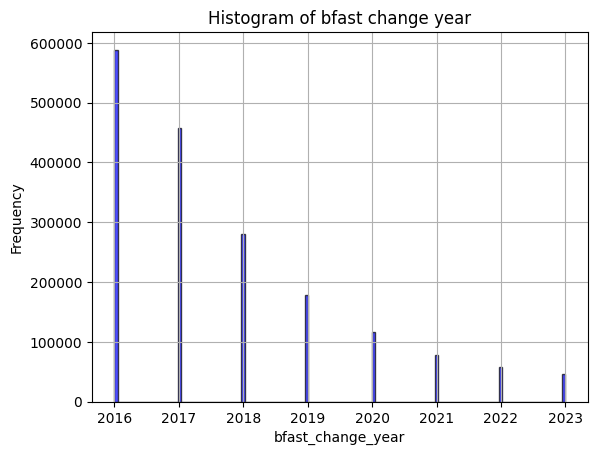

In [78]:
# plot histogram of cusum change
gdf_bfast = gdf[gdf['bfast_change_year']>0]
plt.hist(gdf_bfast['bfast_change_year'], bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of bfast change year')
plt.xlabel('bfast_change_year')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

##### assign change year classes based on classification and cusum dates

In [79]:
#choose which model to use
model = 'CART_pred'

In [80]:
# create hybrid column taking the class from the model you choose and combining with cusum date
def y(x):
  if x[model] == 'Def' and x['cusum_change_year'] == 2016: return 'Def2016'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2017: return 'Def2017'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2018: return 'Def2018'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2019: return 'Def2019'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2020: return 'Def2020'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2021: return 'Def2021'
  elif x[model] == 'Def' and x['cusum_change_year'] == 2022: return 'Def2022'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2016: return 'Deg2016'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2017: return 'Deg2017'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2018: return 'Deg2018'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2019: return 'Deg2019'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2020: return 'Deg2020'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2021: return 'Deg2021'
  elif x[model] == 'Deg' and x['cusum_change_year'] == 2022: return 'Deg2022'
  elif x[model] == 'Def' and x['cusum_change_year'] > 2022: return 'Stable'  
  elif x[model] == 'Deg' and x['cusum_change_year'] > 2022: return 'Stable'  
  elif x[model] == 'Def' and x['cusum_change_year'] < 2016: return 'Stable' 
  elif x[model] == 'Deg' and x['cusum_change_year'] < 2016: return 'Stable' 
  elif x[model] == 'Stable' : return 'Stable'
  elif x[model] == 'NF' : return 'NF'
  else: return ''

gdf['Sim_Ref_Change_Year_1522'] = gdf.apply(y, axis=1)

annual_counts = gdf['Sim_Ref_Change_Year_1522'].value_counts()
annual_counts = annual_counts.sort_index()
print(annual_counts)

Sim_Ref_Change_Year_1522
Def2016       9652
Def2017       7152
Def2018       6701
Def2019       8147
Def2020       9520
Def2021      10256
Def2022       9312
Deg2016       5582
Deg2017       4538
Deg2018       2726
Deg2019       3119
Deg2020       3181
Deg2021       4299
Deg2022       5707
NF          720303
Stable     1163078
Name: count, dtype: int64


In [81]:
#create hybrid column with values keeping interpreted data, and modeled for all the rest
gdf['Sim_CEO_Ref_Change_Type_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Type_1522'], gdf[model])
gdf['Sim_CEO_Ref_Change_Year_1522'] = np.where(gdf['interpreted'] == 1, gdf['Ref_Change_Year_1522'], gdf['Sim_Ref_Change_Year_1522'])

In [82]:
gdf['Sim_CEO_Ref_Change_Type_1522'].value_counts(dropna=False)

Sim_CEO_Ref_Change_Type_1522
Stable    1144012
NF         720252
Def         72422
Deg         36587
Name: count, dtype: int64

In [83]:
gdf['Sim_CEO_Ref_Change_Year_1522'].value_counts(dropna=False).sort_index()

Sim_CEO_Ref_Change_Year_1522
Def2016       9633
Def2017       7190
Def2018       6750
Def2019       8180
Def2020       9534
Def2021      10280
Def2022       9300
Deg2016       5608
Deg2017       4524
Deg2018       2725
Deg2019       3126
Deg2020       3199
Deg2021       4308
Deg2022       5706
NF          720252
Stable     1162958
Name: count, dtype: int64

In [84]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['interpreted'],aggfunc="count",margins=True,
                             margins_name='Total')

interpreted                         0      1    Total
Sim_CEO_Ref_Change_Year_1522                         
Def2016                          9536     97     9633
Def2017                          7033    157     7190
Def2018                          6583    167     6750
Def2019                          8007    173     8180
Def2020                          9374    160     9534
Def2021                         10152    128    10280
Def2022                          9202     98     9300
Deg2016                          5548     60     5608
Deg2017                          4501     23     4524
Deg2018                          2693     32     2725
Deg2019                          3086     40     3126
Deg2020                          3152     47     3199
Deg2021                          4273     35     4308
Deg2022                          5667     39     5706
NF                             713955   6297   720252
Stable                        1157364   5594  1162958
Total                         1960126  13147  1973273

In [85]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Type_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg                         1       2       3    Total
Sim_CEO_Ref_Change_Type_1522                                 
Def                             5707   27942   38773    72422
Deg                            12714   15226    8647    36587
NF                            185565  443704   90983   720252
Stable                        744943  341902   57167  1144012
Total                         948929  828774  195570  1973273

In [86]:
#check that interpreted values sum correctly
pd.pivot_table(gdf,values='point_id',index=['Sim_CEO_Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg                         1       2       3    Total
Sim_CEO_Ref_Change_Year_1522                                 
Def2016                          811    4988    3834     9633
Def2017                          600    2621    3969     7190
Def2018                          351    1705    4694     6750
Def2019                          344    2365    5471     8180
Def2020                          556    2327    6651     9534
Def2021                          751    3274    6255    10280
Def2022                          831    4024    4445     9300
Deg2016                         2188    2606     814     5608
Deg2017                         2117    1583     824     4524
Deg2018                          801    1011     913     2725
Deg2019                          475    1586    1065     3126
Deg2020                          711    1222    1266     3199
Deg2021                         1256    1522    1530     4308
Deg2022                         1980    2486    1240     5706
NF                            185565  443704   90983   720252
Stable                        749592  351750   61616  1162958
Total                         948929  828774  195570  1973273

In [87]:
#use stratum counts to calculate stats from CEO  points
pd.pivot_table(gdf,values='point_id',index=['Ref_Change_Year_1522'],columns=['kmeans_chg'],aggfunc="count",margins=True,
                             margins_name='Total')

kmeans_chg              1    2    3  Total
Ref_Change_Year_1522                      
Def2016               NaN   26   71     97
Def2017                 1   45  111    157
Def2018               NaN   38  129    167
Def2019               NaN   47  126    173
Def2020                 1   35  124    160
Def2021                 2   34   92    128
Def2022                 1   33   64     98
Deg2016               NaN   45   15     60
Deg2017                 1   13    9     23
Deg2018                 1   16   15     32
Deg2019                 2   18   20     40
Deg2020                 1   25   21     47
Deg2021                 1   14   20     35
Deg2022                 1   21   17     39
NF                    509 4121 1667   6297
Stable                708 4012  874   5594
Total                1229 8543 3375  13147

#### plot data

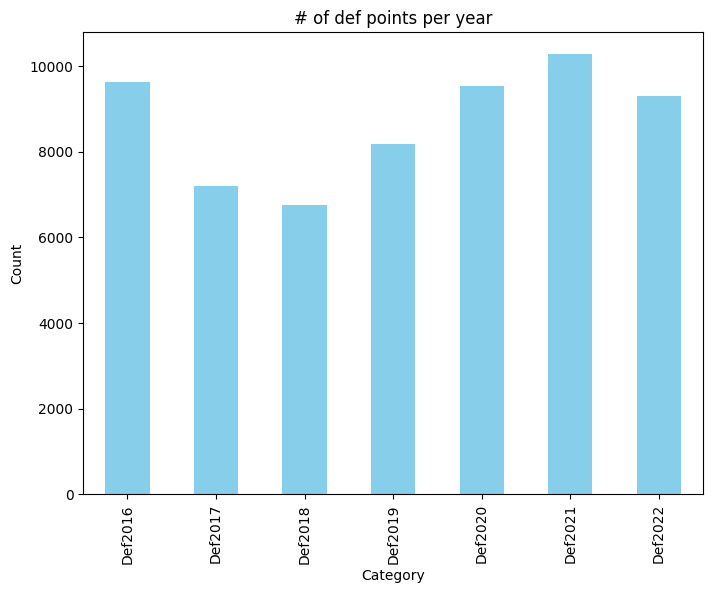

In [88]:
#select the values you want to plot
values_to_plot = ['Def2016','Def2017','Def2018','Def2019','Def2020','Def2021','Def2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_CEO_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of def points per year')

# Show the plot
plt.show()

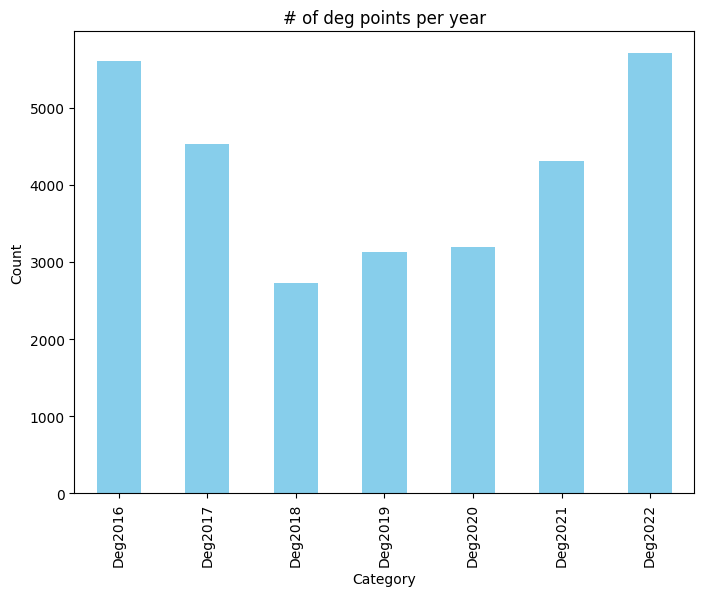

In [89]:
#select the values you want to plot
values_to_plot = ['Deg2016','Deg2017','Deg2018','Deg2019','Deg2020','Deg2021','Deg2022']

# Filter the DataFrame to include only the selected values
filtered_df = gdf[gdf['Sim_CEO_Ref_Change_Year_1522'].isin(values_to_plot)]

# Get the value counts and sort by index (alphabetically)
defvalue_counts = filtered_df['Sim_CEO_Ref_Change_Year_1522'].value_counts().sort_index()

# Plot the value counts as a bar graph
plt.figure(figsize=(8, 6))  # Optional: Set the figure size
defvalue_counts.plot(kind='bar', color='skyblue')


# Set plot labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('# of deg points per year')

# Show the plot
plt.show()

In [90]:
gdf.to_csv(out_file,index=True)